In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(plyr))

suppressMessages(library(caret))

suppressMessages(library(openair))
suppressMessages(library(gridExtra))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

load("data/data_AQ.rda")
load("data/meteorology.rda")

# Lockdown dates

In [4]:
periods <- list(
    # lockdown
    lockdown = ymd("2020-03-14"),
    #end.lockdown = as.numeric(ymd_hms("2020-04-28 00:00:00")),

    # poslockdown
    fases = ymd("2020-05-01"),
    normalidad = ymd("2020-06-21"),

    # New lockdown
    new.lockdown = ymd("2020-10-25")
)

## Load Data

In [5]:
aq <- data_AQ[data_AQ$site == "es0118a", ] %>%
            filter(variable == "no2") %>%
            timeAverage(avg.time = "day")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es0118a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)
head(df)

,date,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,41.95833,0.8571429,225.29494,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
2,2013-01-02,59.91667,0.9321429,355.50018,1027.800,5.8,0,0.7,10.8,950.3,945.9,75.60469,71.71485
3,2013-01-03,67.41667,0.8607143,75.49246,1036.733,6.8,0,2.8,10.8,959.8,950.3,67.31548,84.82211
4,2013-01-05,86.33333,0.4500000,261.60039,1035.133,4.9,0,-0.4,10.2,956.8,952.9,73.00545,110.16858
5,2013-01-06,70.04167,0.4892857,178.49970,1031.567,5.1,0,0.7,9.5,953.0,949.6,80.61580,111.74950
6,2013-01-07,48.70833,0.4107143,278.81272,1031.000,3.2,0,1.5,4.8,951.3,949.6,86.99924,112.96824


In [6]:
train.smp <-  which(df$date < ymd("2020-01-01"))

In [7]:
df.data <- df %>%
        select(-date) %>% 
        data.frame()
time <- df$date

In [8]:
df.apply <- apply(df.data, 2, function(cl) {
    dcomp <- decompose(ts(cl, frequency = 365))
    
    cl - dcomp$seasonal
}) %>% data.frame()

```R
df.data <- apply(df.data, 2, function(cl){cl+abs(min(cl))}) %>%
                data.frame()
```

## Analysis

In [9]:
anly.data <- df.apply

In [10]:
fit.th <- train(value ~., df.data, subset = train.smp,
                 preProcess = c("center", "scale"),
                 method = "glm", family=Gamma
                )
y.train <- predict(fit.th, newdata=anly.data[train.smp, ])

```R
fit.th <- glm(value ~., data = anly.data, subset=train, family=Gamma(link = "log"))
```

In [11]:
test <- which(df$date > ymd("2020-01-01"))
y.test <- predict(fit.th, newdata = anly.data[test,])

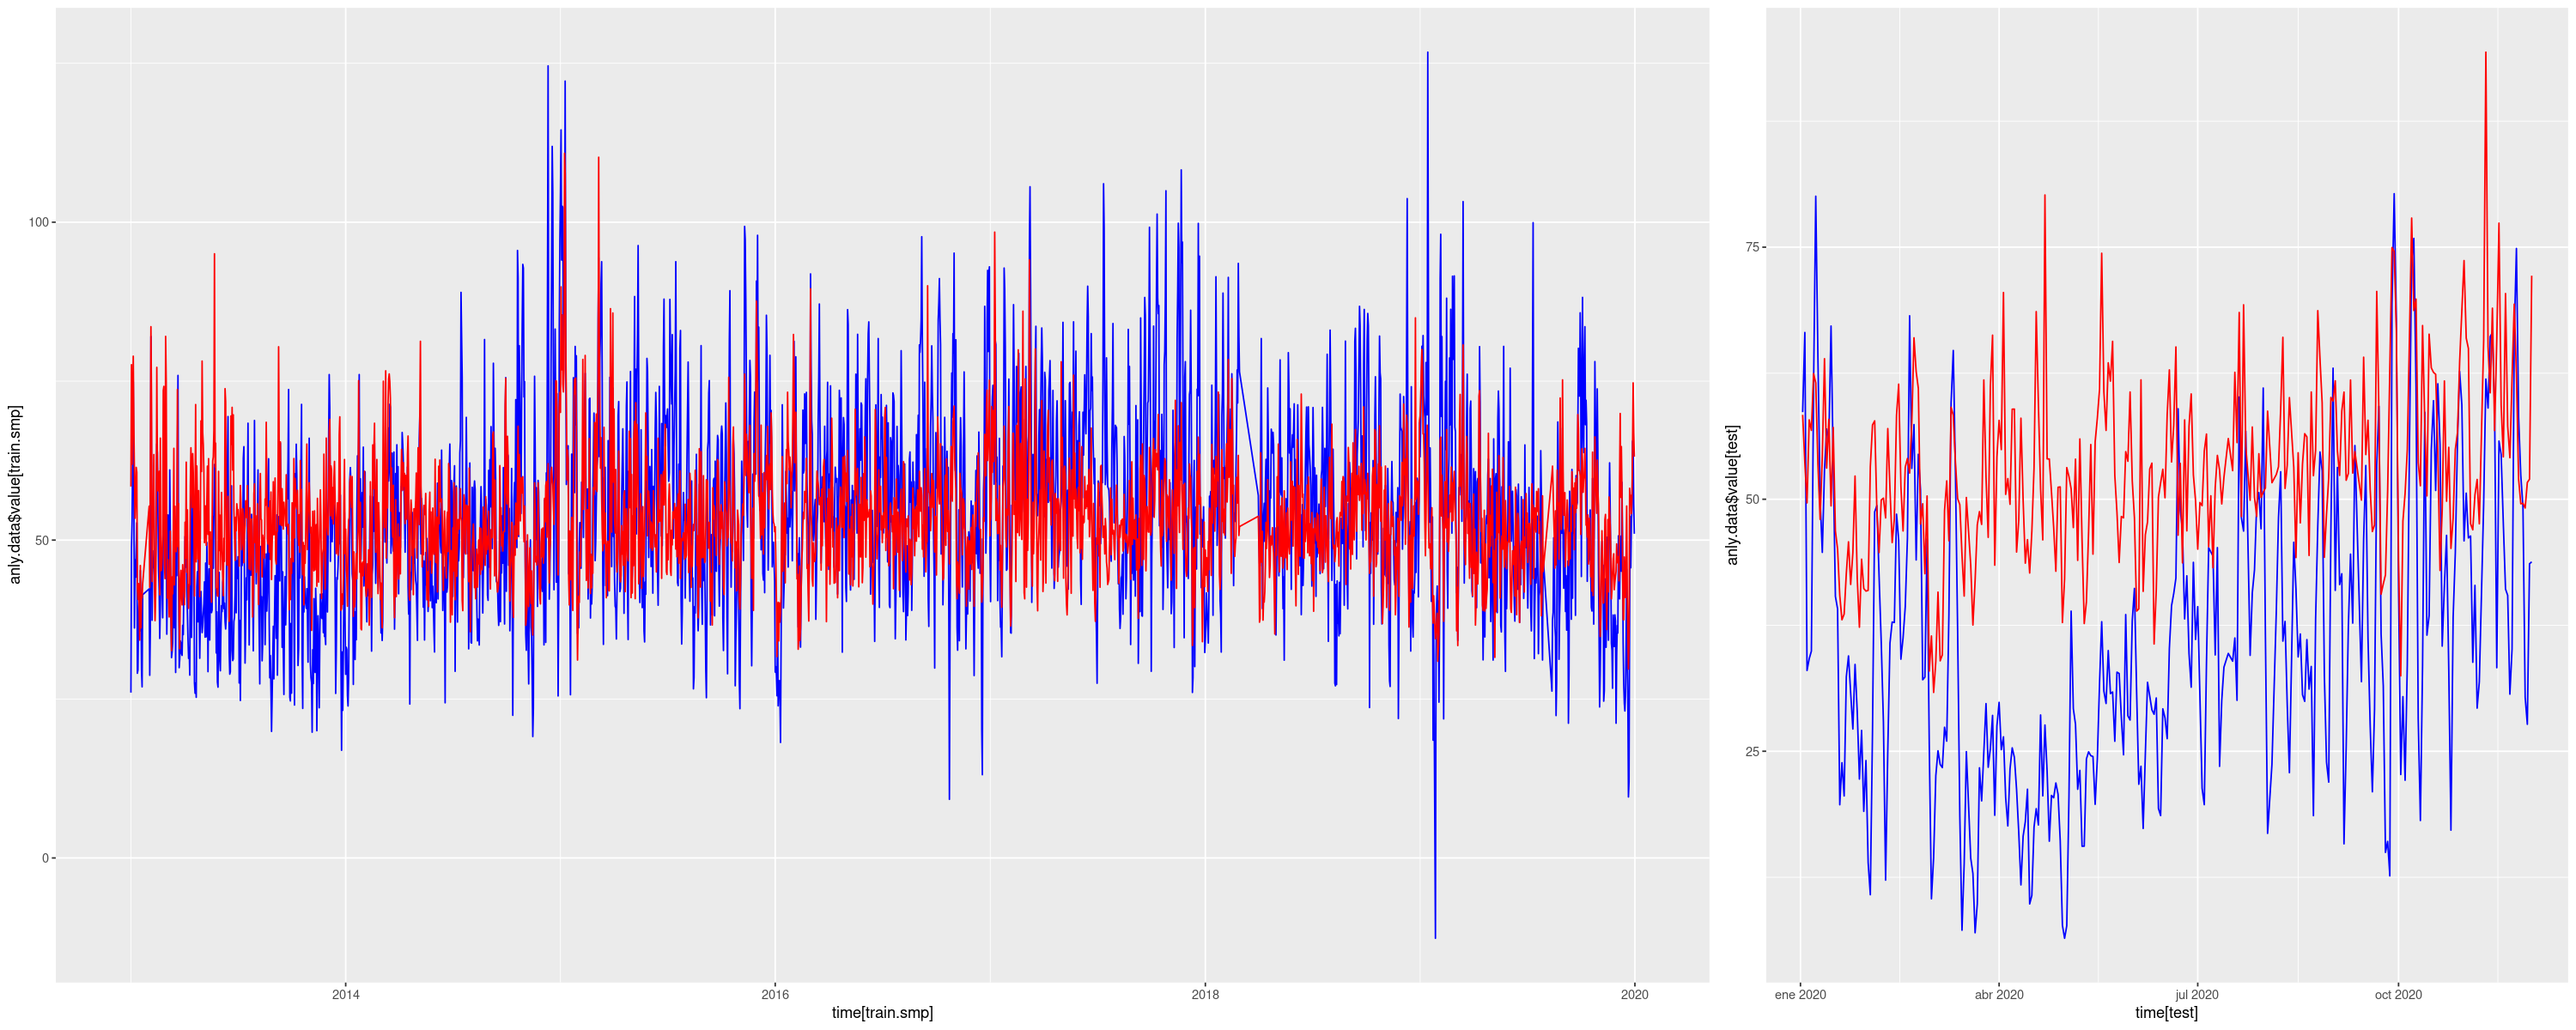

In [12]:
all.series <- ggplot() +
                geom_line(aes(x = time[train.smp], y = anly.data$value[train.smp]), color="blue") +
                geom_line(aes(x = time[train.smp], y = y.train), color="red")
last.series <- ggplot() +
                geom_line(aes(x = time[test], y = anly.data$value[test]), color="blue") +
                geom_line(aes(x = time[test], y = y.test), color="red")

grid.arrange(all.series, last.series, nrow = 1, widths = c(2, 1))

## Using `segmented` package

In [13]:
suppressMessages(library(segmented))

var <- data.frame(y = (anly.data$value[test] - y.test),
                  x = as.numeric(time[test]))

my.seg.1 <- segmented(lm(y ~ x, data=var), 
                      seg.Z = ~ x,
                      psi = list(x = periods)
                     )

Warning message:
“No breakpoint estimated”


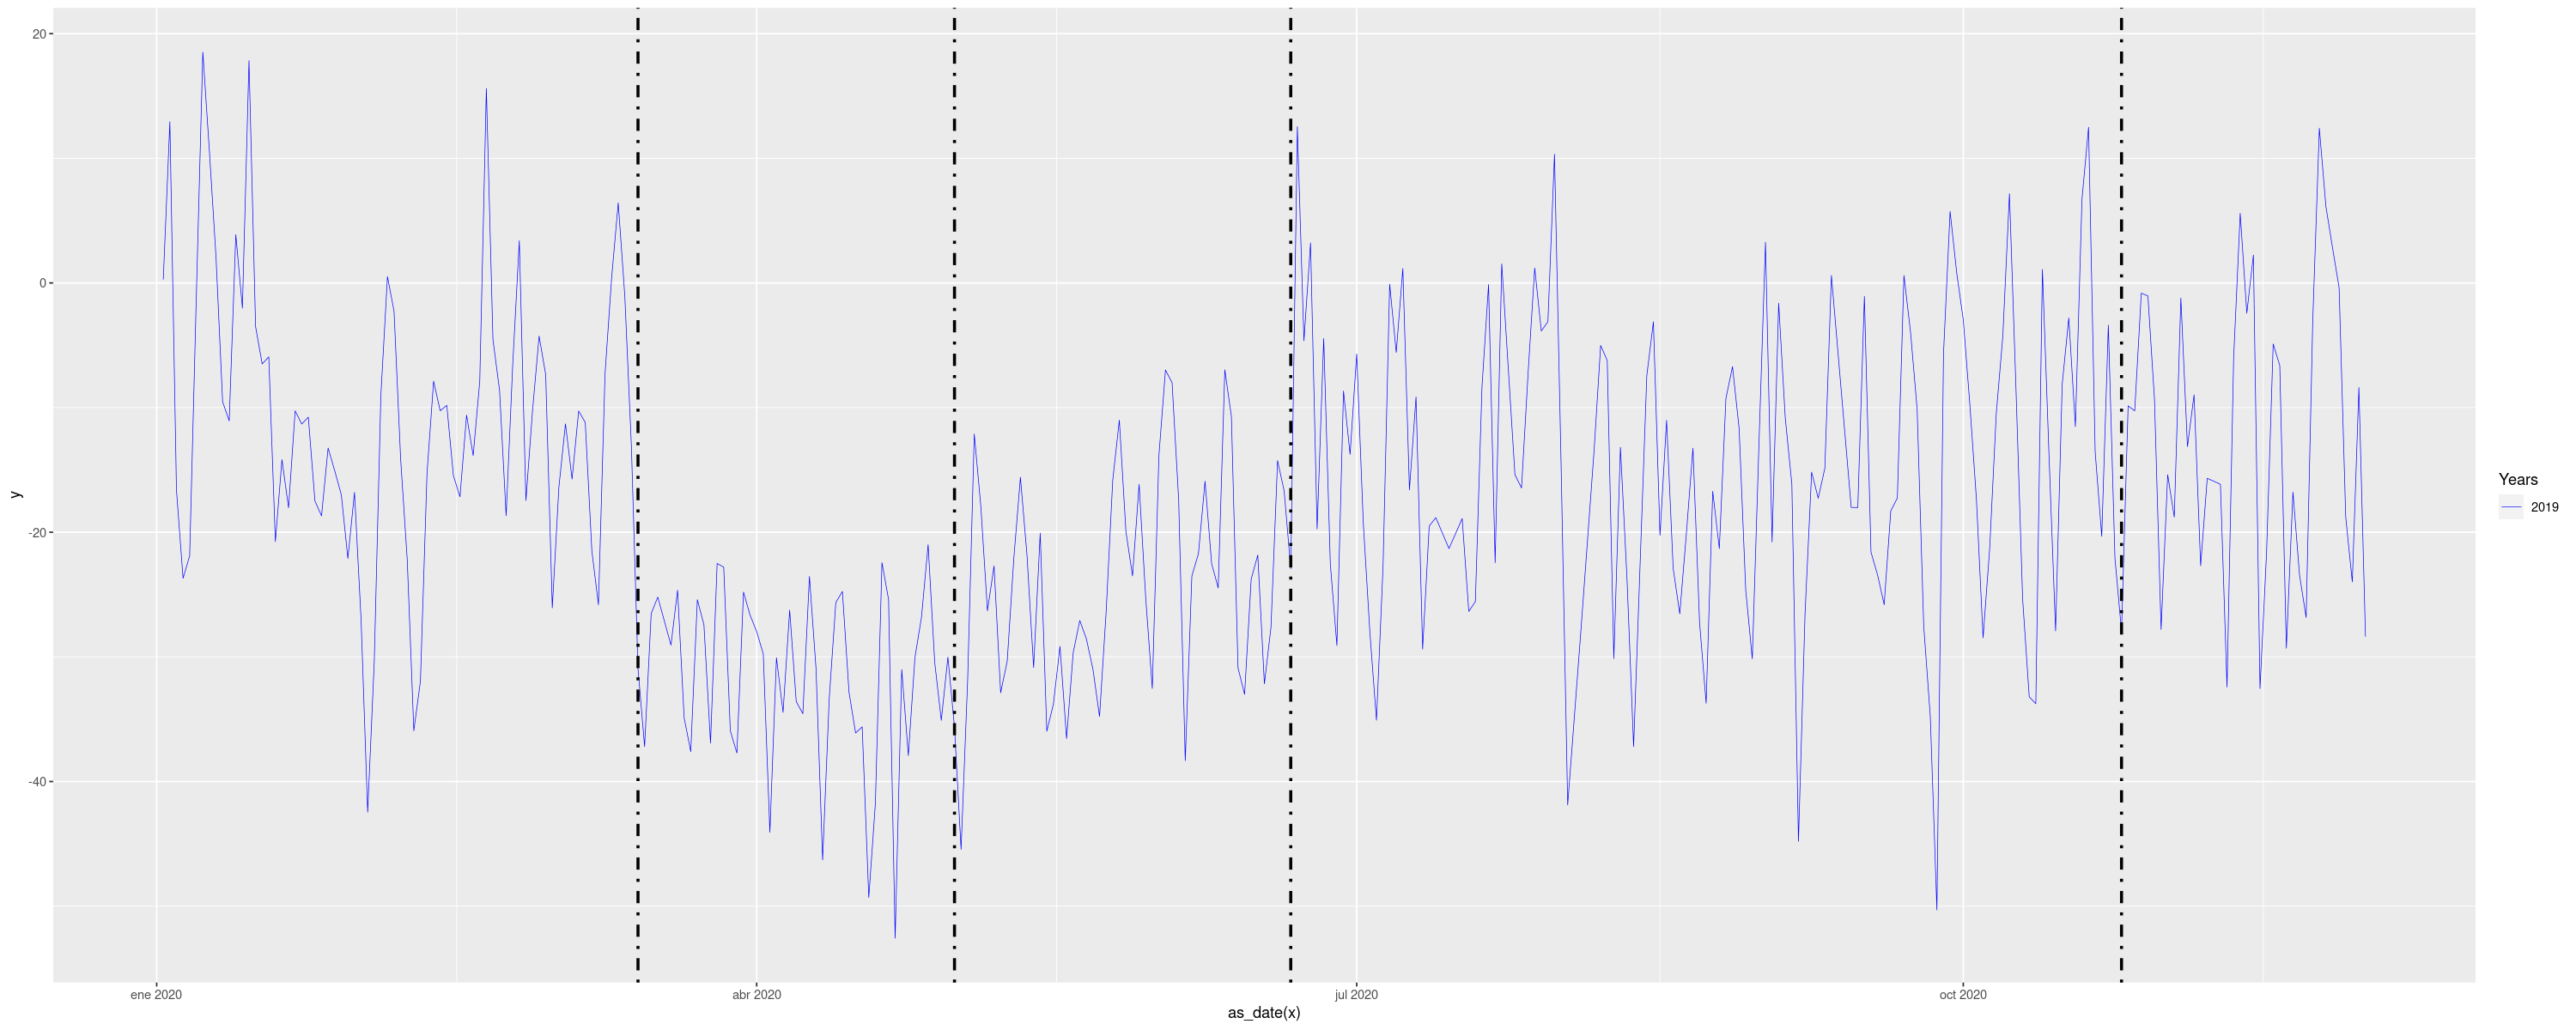

In [14]:
plot <- ggplot(data=var, aes(x=as_date(x)))+ 
    scale_color_manual(name = "Years", 
                       values = c("2019" = "blue"))

plot <- plot + geom_line(aes(y=y, color="2019"), size=0.2)

if (length(my.seg.1$psi) != 0) {
    for (k in 1:(nrow(my.seg.1$psi))) {
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."], 
                                  linetype=5, color = "red", size=1.5)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] - my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
        plot <- plot + geom_vline(xintercept = my.seg.1$psi[k,"Est."] + my.seg.1$psi[k,"St.Err"], 
                                  linetype=5, color = "orange", size=1)
    }
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=4, color = "black", size=1)
}

plot

In [15]:
as_date(my.seg.1$psi[, "Est."])
as_date(my.seg.1$psi[, "Initial"])

Date of length 0

Date of length 0

## Using `strucchange` package

In [16]:
suppressMessages(library(strucchange))

my.other.seg.1 <- breakpoints(y ~ x+1, 
                              h = 0.15, 
                              breaks = 4,
                              data = var)
new.breaks.1 <- as_datetime(my.other.seg.1$breakpoints)

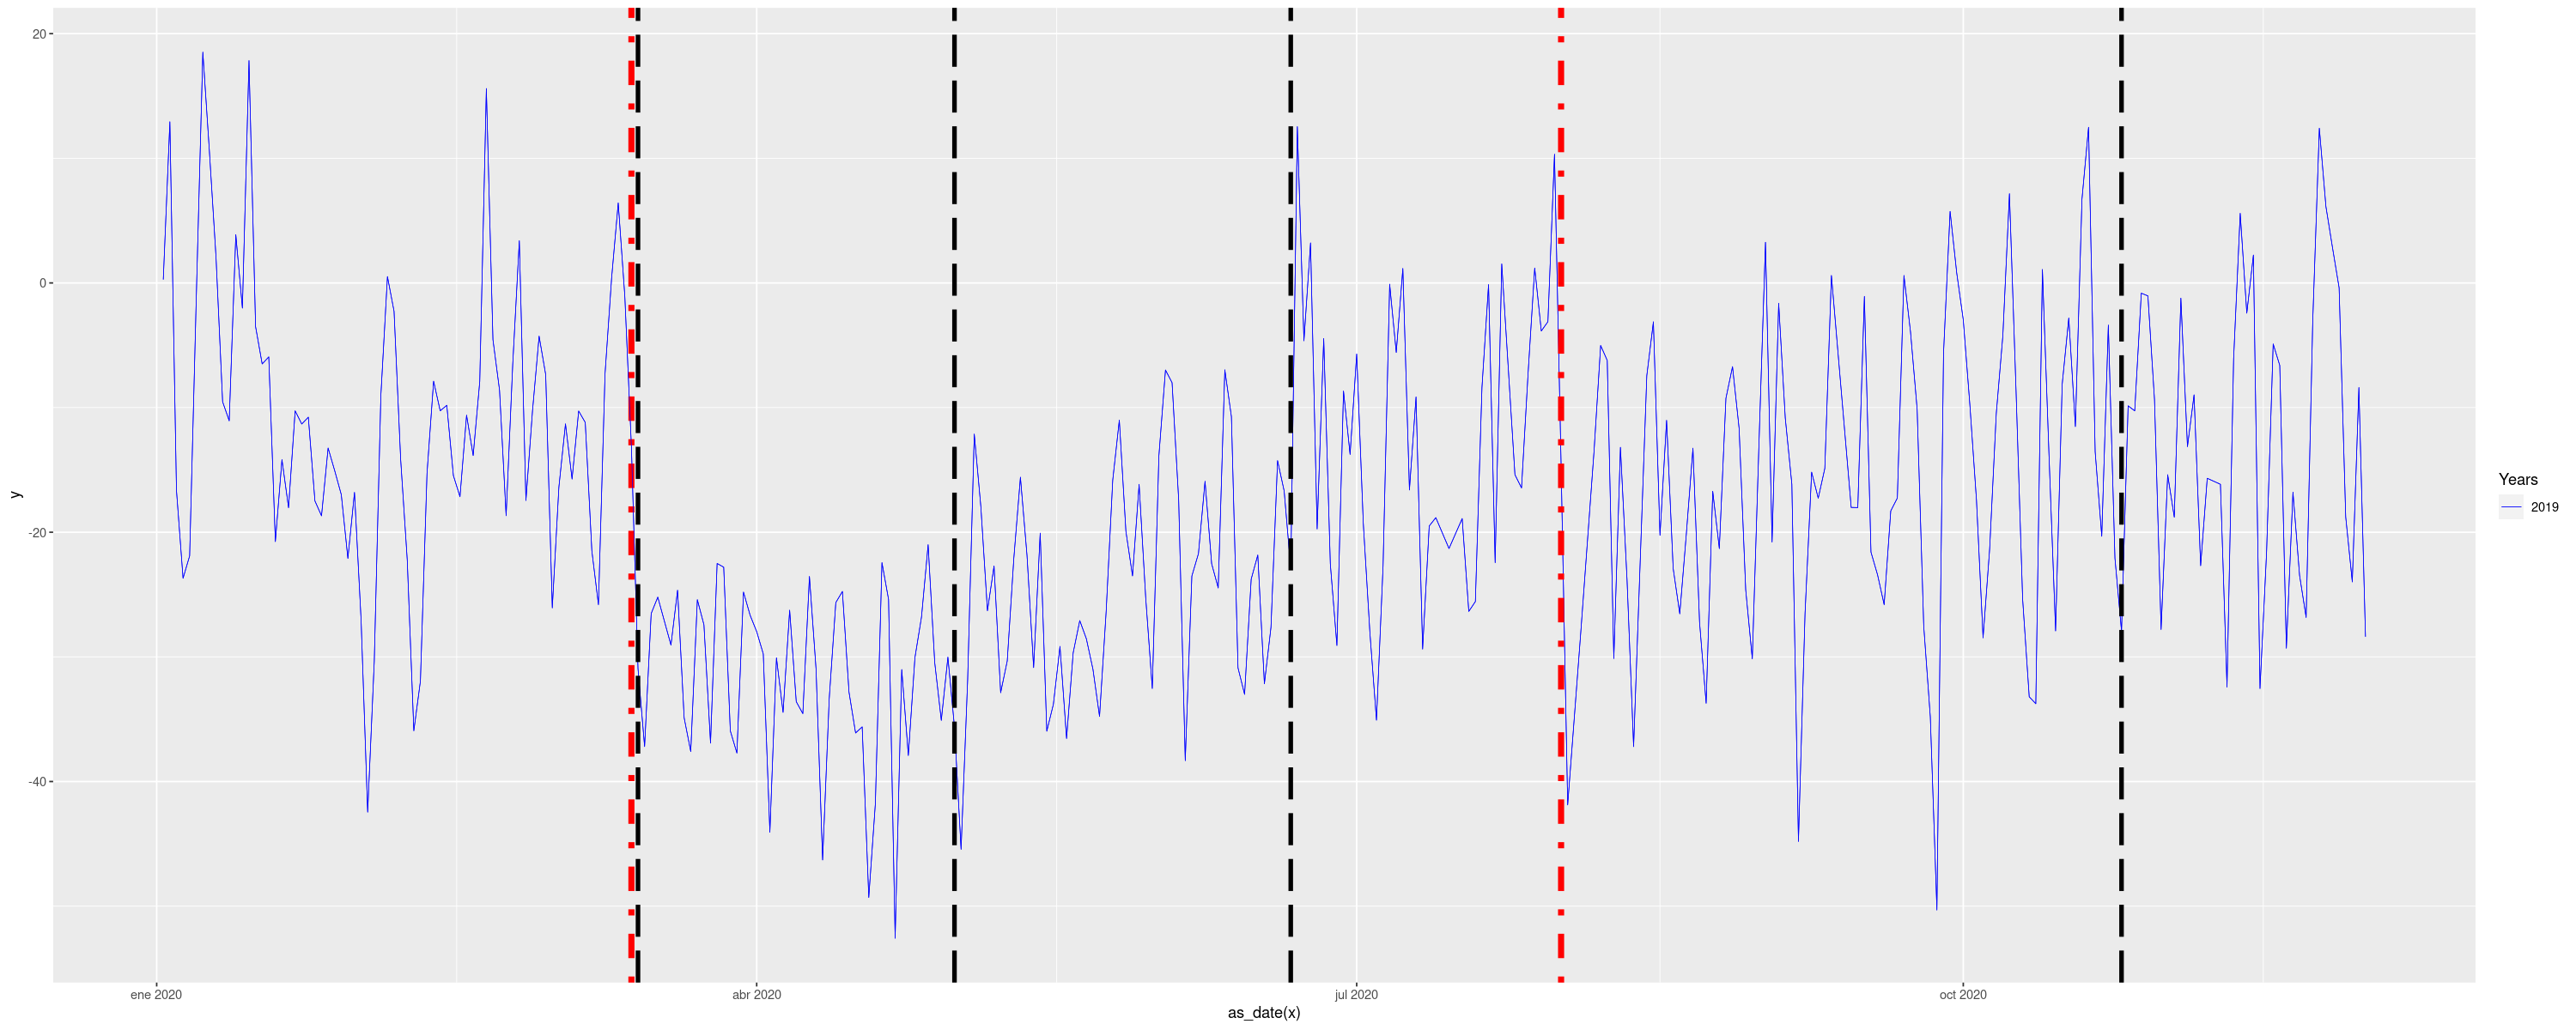

In [17]:
plot <- ggplot(data=var, aes(x=as_date(x))) + 
        scale_color_manual(name = "Years", values = c("2019" = "blue"))
for (k in 1:(length(new.breaks.1))) {
    plot <- plot + geom_line(aes(y=y, color="2019"), size=0.2)
    plot <- plot + geom_vline(xintercept = var$x[new.breaks.1[k]], 
                              linetype=4, color = "red", size=2)
}

for (k in 1:(length(periods))) {
    plot <- plot + geom_vline(xintercept = as.numeric(periods[k]), 
                              linetype=5, color = "black", size=1.5)
}

plot 

In [18]:
time[test][new.breaks.1]

[1] "2020-03-13" "2020-08-01"

## Relative Change

In [19]:
data.prd.raw <- list()
data.prd.model <- list()

new.periods <- c(as.numeric(ymd("2020-01-01")), periods, as.numeric(max(time)))

for (i in 2:length(new.periods)) {
    data.prd.raw[[names(periods)[i-1]]] <- mean(anly.data$value[which(time < new.periods[i] &
                                                       time > new.periods[i-1])])
    data.prd.model[[names(periods)[i-1]]] <- mean(y.test[which(time < new.periods[i] &
                                                       time > new.periods[i-1])-length(train.smp)])
}

In [20]:
names(data.prd.model)[5] <- "end.year"
names(data.prd.raw)[5] <- "end.year"

In [21]:
data.prd.model

$lockdown
[1] 49.29121

$fases
[1] 51.40817

$normalidad
[1] 52.05595

$new.lockdown
[1] 54.86855

$end.year
[1] 60.37174

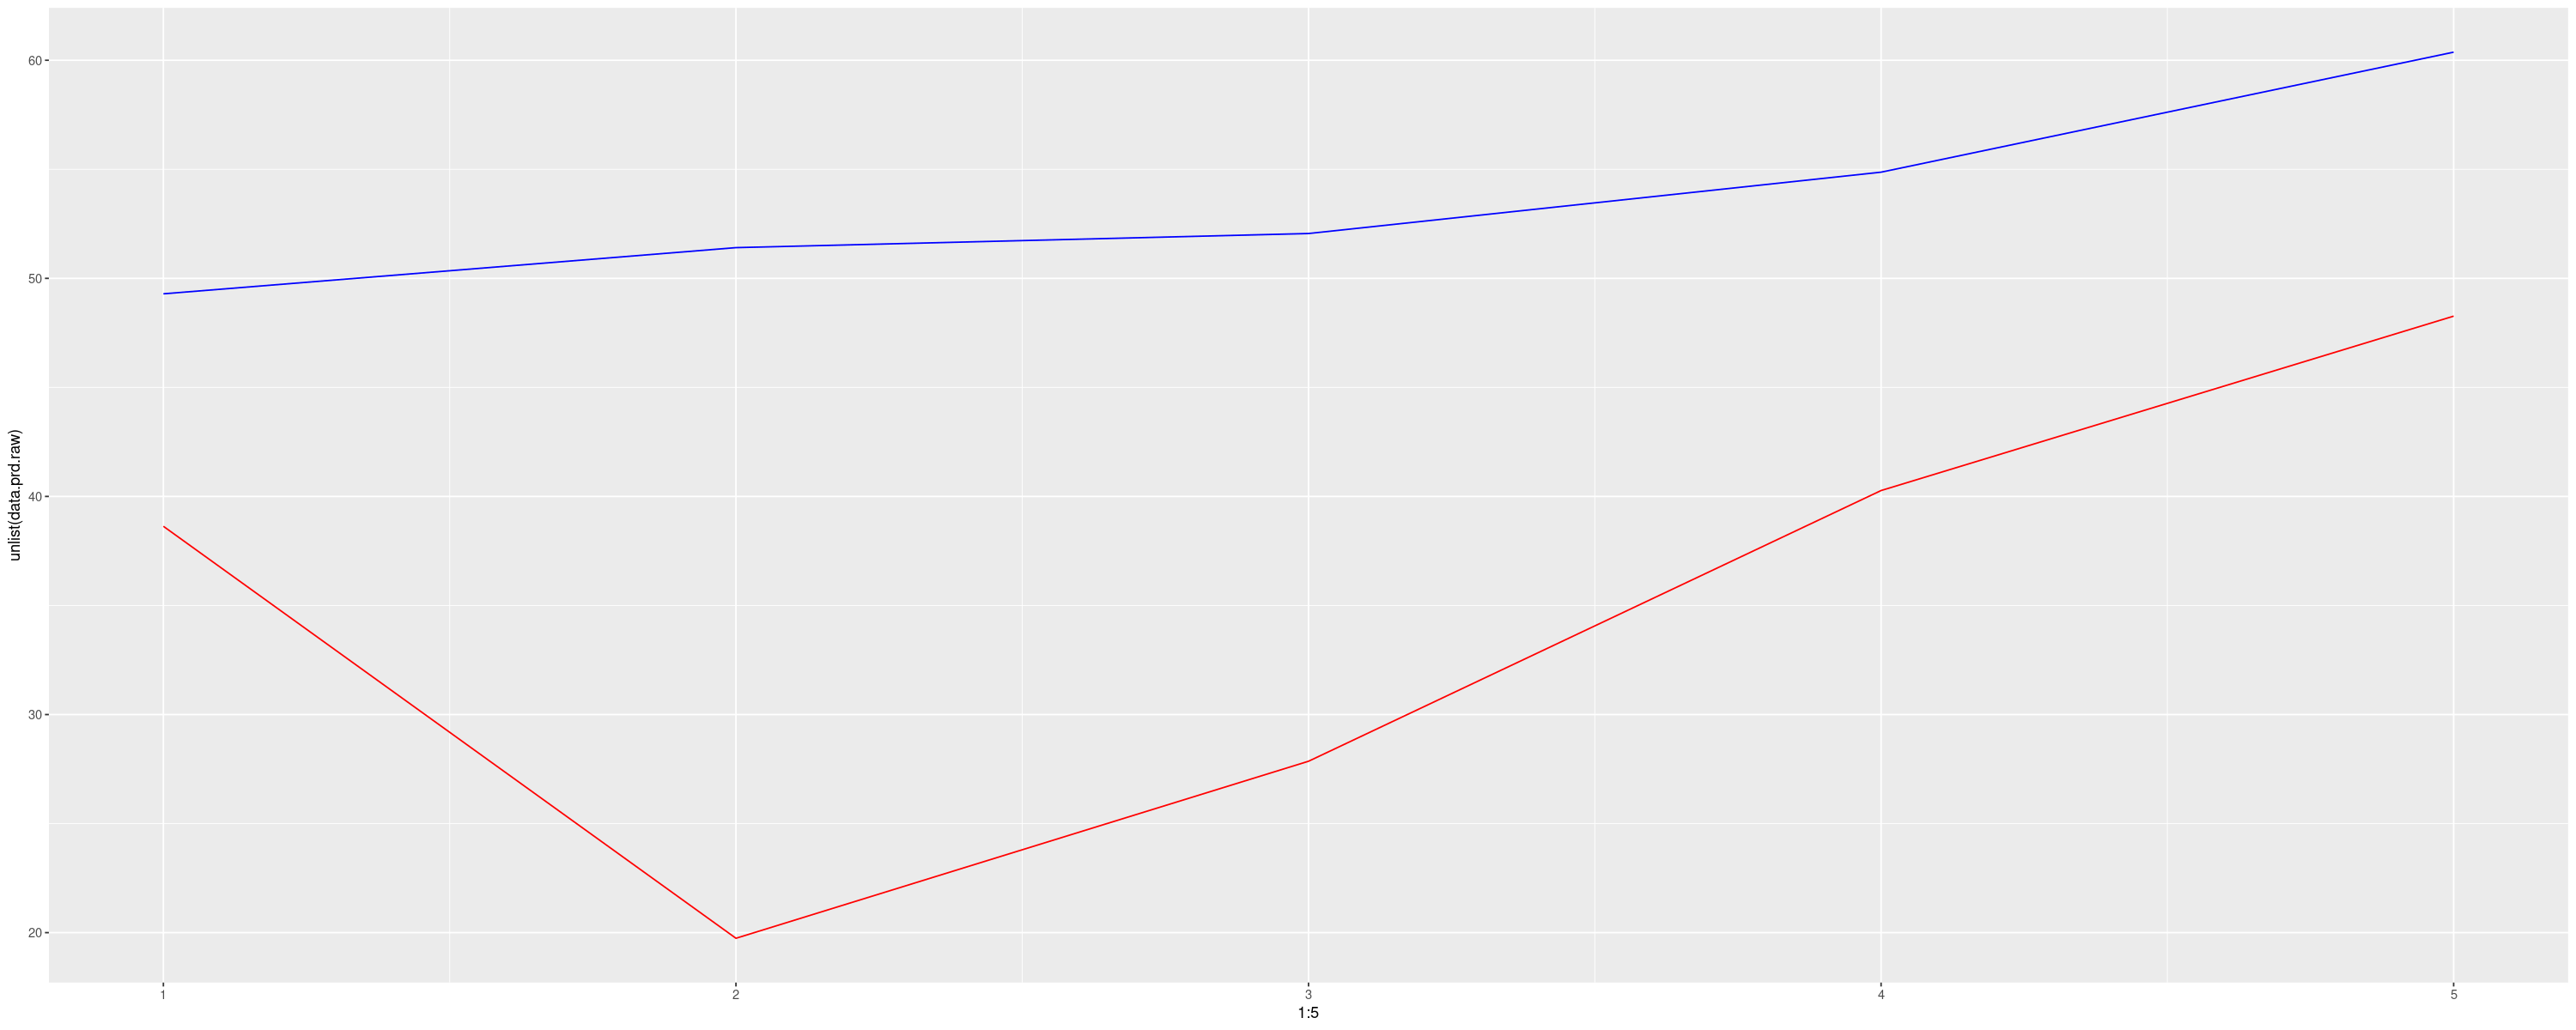

In [22]:
ggplot() +
    geom_line(aes(x=1:5, y=unlist(data.prd.raw)), color="red") +
    geom_line(aes(x=1:5, y=unlist(data.prd.model)), color="blue")

In [23]:
change <- list()

for (nm in names(data.prd.model)) {
    x <- unlist(data.prd.raw)
    y <- unlist(data.prd.model)
    #f.x.y <- min(c(abs(y)))
    f.x.y <- abs(data.prd.model[[nm]])
    change[[nm]] <- ((data.prd.raw[[nm]] - data.prd.model[[nm]]) 
                     / f.x.y)
}

change

$lockdown
[1] -0.2162705

$fases
[1] -0.6159808

$normalidad
[1] -0.4648271

$new.lockdown
[1] -0.26604

$end.year
[1] -0.2004919